In [12]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, cm_pmos, spice_sim
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [15]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/sky130A_LUT_lvt.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                       # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp = 20e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,7.500000e-05
R1,4.000000e+03
R2,1.200000e+04


In [16]:
Vota = 1.122

In [17]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"), 
        Symbol("W_diff_m2"), Symbol("L_diff_m2"), 
        Symbol("W_aload"), Symbol("L_aload"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

In [18]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*1.8)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [19]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

In [20]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.2924829  -0.36213516 -0.37854652 -0.37499057 -0.37821294]
length
vgs
0


In [21]:
pt.W

array([[0.0007249 ],
       [0.00284592],
       [0.0068124 ],
       [0.01471841],
       [0.03210323]])

In [23]:
## DIFF PAIR PRIMITIVE #####################################################################

sweep_size_dp = 3
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(vcp_dp, vs_dp, vin_dp, vout_dp, I_amp/2, sweep_size_dp, lengths_nmos, vout_dp + 0.5, lut_file, lut_w)
diffpair_primitive_df = diffpair_primitive.build()     
diffpair_primitive_df = diffpair_primitive_df.dropna()
diffpair_primitive_df = diffpair_primitive_df[(diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>1e-6)]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      lut_file=lut_file,
                      lut_w = lut_w,
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': OTA_macro.electrical_parameters["Vout"]-OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': OTA_macro.electrical_parameters["Vout"]-OTA_macro.electrical_parameters["Vdd"], 
                              'il': OTA_macro.electrical_parameters["Il"]/2,
                              'length': lengths_nmos, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload_1"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

vds
vgs
1
M1 jd:  [[2.85414115e+01 1.52638846e-01 9.02226846e-06 2.87784715e+01
  1.56679911e-01 9.61295900e-06 2.90039480e+01 1.60691664e-01
  1.00536387e-05]
 [1.67989462e+01 1.56665879e-01 7.75901808e-06 1.68841775e+01
  1.59653540e-01 8.12249846e-06 1.69657584e+01 1.62653098e-01
  8.39005852e-06]
 [9.66207010e+00 1.44304586e-01 5.83677543e-06 9.69719329e+00
  1.46331303e-01 6.05588940e-06 9.73089469e+00 1.48378109e-01
  6.21632138e-06]
 [5.20462397e+00 1.06366463e-01 3.94912245e-06 5.21661625e+00
  1.07339809e-01 4.06183109e-06 5.22829141e+00 1.08332077e-01
  4.14085770e-06]
 [2.66046500e+00 6.59793009e-02 2.73402271e-06 2.66497951e+00
  6.64110401e-02 2.80122984e-06 2.66936908e+00 6.68534840e-02
  2.84588327e-06]]
M1 gmid:  [[ 6.3103474  23.97311229 28.34914936  6.30271006 23.93041541 28.34087845
   6.29423476 23.88890967 28.33308322]
 [ 5.83772708 23.37776339 29.6851253   5.83170157 23.31640798 29.67479729
   5.82503034 23.25644964 29.66492027]
 [ 5.49086775 22.36727011 31.254680

In [24]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.3942394256591797
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.07648062705993652
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.04413104057312012
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*g

In [25]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df = ota_df[(ota_df["gain"]>30) & (ota_df["area"]<1e-3)]

/tmp/ipykernel_1993/1372198696.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper right')


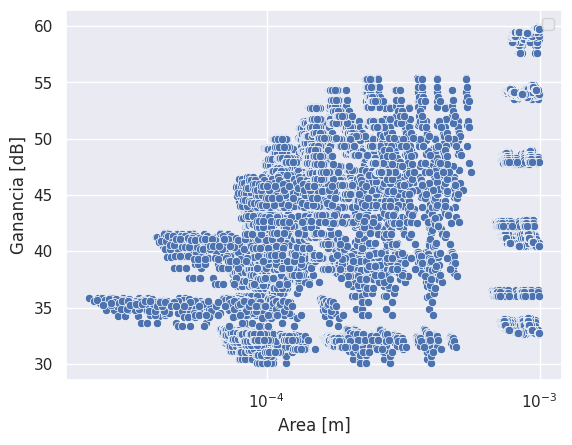

In [26]:
sns.scatterplot(data=ota_df, x="area", y="gain")
plt.xlabel(r"Area [m]")
plt.ylabel(r"Ganancia [dB]")
plt.locator_params(axis='x', nbins=10) 
plt.legend(loc = 'upper right')
plt.xscale("log")
plt.xscale("log")

plt.savefig('gain_topo2.pdf')